<a href="https://colab.research.google.com/github/zsnoori/NMA_DL_FER/blob/master/Using_FER_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Facial Emotion Recognision Model
During Neuro Mach Academy summer school 2023 Deep Learning course, We developed a model based on ResNet18 to predict emotions based of facial images.

In this noteook I use a model on new images.<br>
There are 4 ways for input images:<br>
- an image address
- a folder path which contains images
- a dataset of images
- a dataset of images and an index to proceed junst one image

images will normalize and feed into model. Then plotted images are shown with predicted emotions and true emotion if available.


## Code

In [46]:
# @title Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import os

In [4]:
# @title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
device = set_device()
use_cuda = True if (device=='cuda') else False

In [84]:
# @title predictor class

class EmotionPredictor:
    mean, std = [0.485, 0.485, 0.485], [0.229, 0.229, 0.229] # ImageNet mean ans std
    # mean, std = [0.4105, 0.4105, 0.4105], [0.2672, 0.2672, 0.2672] # Calculated mean and std of FER2013self.mean =
    labels = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
    transforms = transforms.Compose([transforms.ToPILImage(),
                                          transforms.Grayscale(num_output_channels=3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean, std)])
    no_label_text = "No True Label"
    def __init__(self, model):
        self.model = model
        # Load model in evaluation state
        self.model.eval()
    def plot_image(self,image, predicted_label, true_label=no_label_text):
        plt.figure(figsize=(2.5, 2.5))
        plt.imshow(image, cmap="gray")
        if true_label==self.no_label_text:
          title_text = f"Predicted emotion: {predicted_label}"
        else:
          title_text = f"True emotion:{true_label}\n Predicted emotion:{predicted_label}"
        title_color = 'green' if true_label==predicted_label else 'red'
        title_color = 'orange' if true_label==self.no_label_text else title_color
        plt.title(title_text, fontsize=10, color=title_color)
        plt.axis('off')
        plt.show()

    def plot_images(self, images, predicted_labels, true_labels=None, rows=1, cols=1):
        num_images = len(images)
        total_subplots = rows * cols
        # If the number of images is less than the total number of subplots, adjust the rows
        if num_images < total_subplots:
            rows = (num_images + cols - 1) // cols
        # Calculate the figure size based on the number of rows and columns
        fig_width = 12  # Adjust this value as needed
        fig_height = rows * (fig_width / cols)
        # Create a grid of subplots with 'rows' rows and 'cols' columns
        fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
        # Flatten the 2D array of axes into a 1D array for easier indexing
        axes = axes.flatten()
        # Loop through the images and labels, and display them in the subplots
        for i, ax in enumerate(axes):
            # Hide empty subplots if there are fewer images than total subplots
            if i >= num_images:
                ax.axis('off')
                continue
            # Plot the image
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')  # Turn off axis ticks and labels
            # Set the title with line breaks to avoid overlapping of long labels
            if true_labels is None or true_labels[i]==self.no_label_text:
              title_text = f"Predicted emotion: {predicted_labels[i]}"
              title_color = 'orange'
            else:
              title_text = f"True emotion: {true_labels[i]}\nPredicted emotion: {predicted_labels[i]}"
              title_color = 'green' if true_labels[i]==predicted_labels[i] else 'red'
            ax.set_title(title_text, fontsize=10, color=title_color)

        # Adjust spacing between subplots and display the plot
        plt.tight_layout()
        plt.show()

    def predict_emotion(self, image):
        # Convert the image to a PyTorch tensor and add a batch dimension
        img = torch.from_numpy(image).float()
        # normalization and needed transforms
        img = self.transforms(img)
        # Add a batch dimension at the beginning
        img = img.unsqueeze(0)  # Add a batch dimension at the beginning
        with torch.no_grad():
            outputs = self.model(img)
        softmax_probs = F.softmax(outputs, dim=1)
        predicted_emotion = self.labels[torch.argmax(softmax_probs).item()]
        return predicted_emotion

    def predict_emotion_from_dataset(self, dataset, idx =None):
      # Load images from dataset
        dataset.columns = dataset.columns.str.replace(' ', '')
        images = dataset['pixels'].str.split(expand=True).values.astype(int)
        true_label = dataset['emotion'] if 'emotion' in dataset.columns else None
        images = images.reshape(-1, 48, 48)
        # if idx is provided, an image will be predicted and plotted
        if idx is not None:
          img = images[idx]
          tlabel = self.labels[true_label[idx + min(dataset.index)]]
          plabel = self.predict_emotion(img)
          self.plot_image(img, plabel, tlabel)
          return

        # predict all images in the dataset
        tlabels = []
        plabels = []
        for idx, img in enumerate(images):
          tlabels.append(self.labels[true_label[idx + min(dataset.index)]])
          plabels.append(self.predict_emotion( img))
        # plot images
        row_num = int(len(images) / 4 +1)
        self.plot_images(images, plabels,tlabels,rows= row_num, cols=5)

    def predict_emotion_from_image(self, image_path):
        image_extensions = (".png", ".jpg", ".jpeg", ".gif", ".bmp", ".tiff")
        if os.path.isfile(image_path) and image_path.lower().endswith(image_extensions):
          img = Image.open(image_path).convert('L')
          img.thumbnail((48, 48))  # resizes image in-place
          img = np.asarray(img)
          predicted_emotion = self.predict_emotion(img)
          self.plot_image(img,predicted_emotion)
          return
        if os.path.isdir(image_path):
          for  image in image_path:
            images = []
            for file in os.listdir(image_path):
                if file.lower().endswith(image_extensions) and os.path.isfile(os.path.join(image_path, file)):
                    images.append(os.path.join(image_path,file))
          plabels = []
          imgs =[]
          for img in images:
            img = Image.open(img).convert('L')
            img.thumbnail((48, 48))  # resizes image in-place
            img = np.asarray(img)
            imgs.append(img)
            plabels.append(self.predict_emotion(img))
          # plot images
          row_num = int(len(imgs) / 4 +1)
          self.plot_images(imgs, plabels,rows= row_num, cols=5)
          return
        raise ValueError("Invalid input. Please provide either  \n-'image_path'  \n-'image_folder' containing images.")


## Examples

In [ ]:
# @title Load saved model
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Logs/Models/model-T_acc70.08-2023-07-24-13-05-11.pt" # @param
model = torch.load(saved_model_path, map_location=torch.device('cpu'))

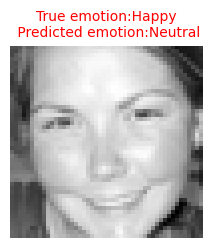

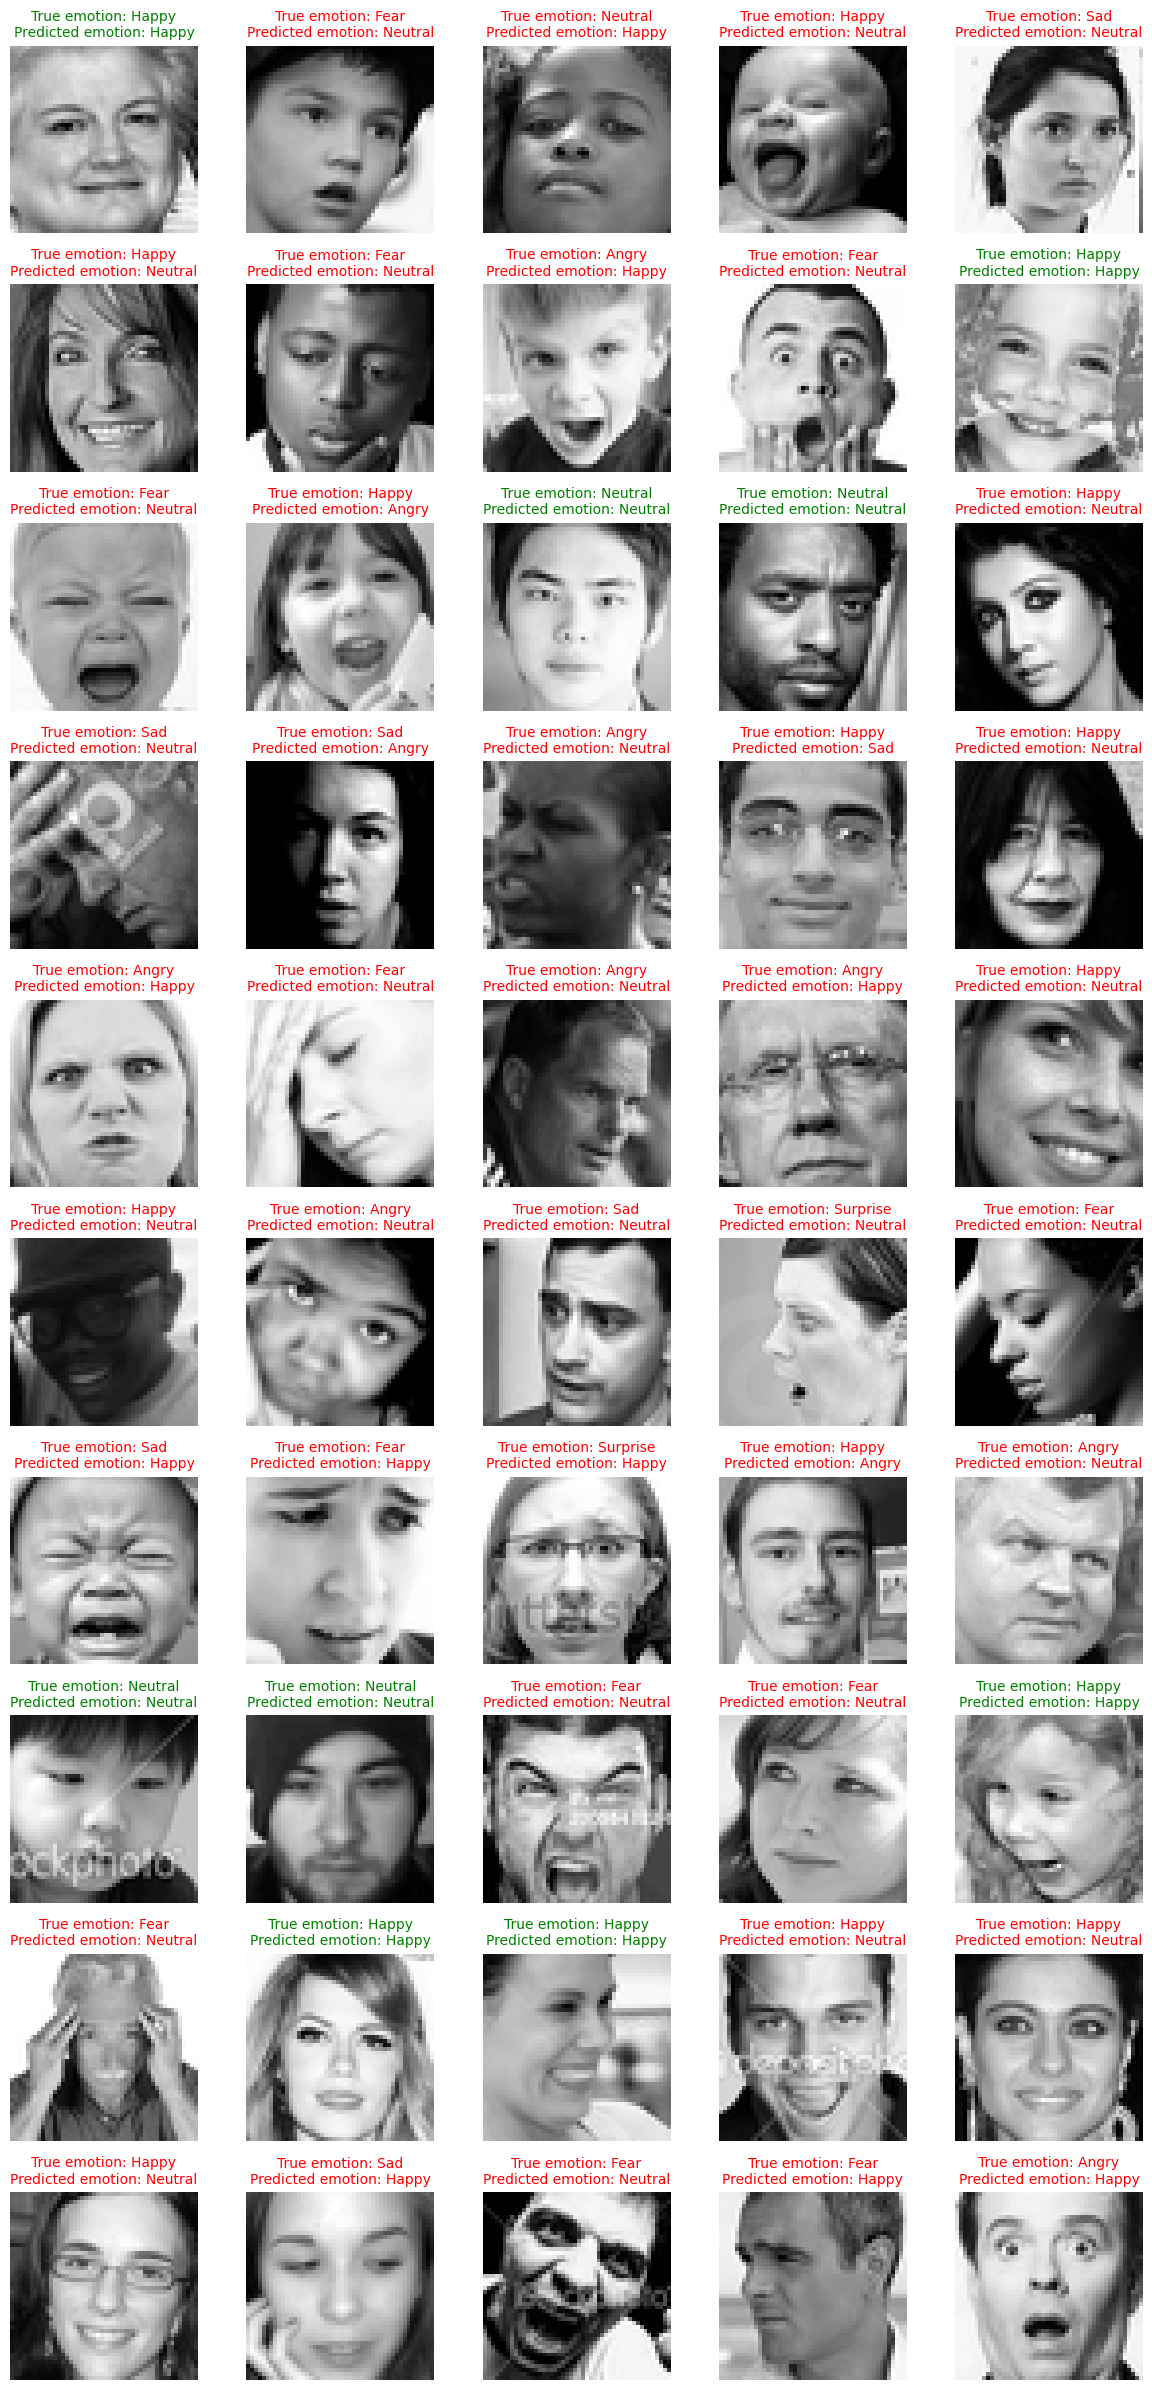

In [88]:
# Create an instance of the EmotionPredictor class
predictor = EmotionPredictor(model)

# Load a dataset of image
test_set_path = "/content/drive/MyDrive/Colab Notebooks/datasets/fer2013/train.csv"
test_set = pd.read_csv(test_set_path)
# Use the method for dataset and index input
predictor.predict_emotion_from_dataset(test_set[5:15],3)

# Use the method for dataset
predictor.predict_emotion_from_dataset(test_set[100:150])

# # Use the method for image input
# image_path = "/content/drive/MyDrive/Colab Notebooks/happy face-queared.jpg"
# predictor.predict_emotion_from_image(image_path)

# image_folder = "/content/drive/MyDrive/Colab Notebooks/FER_images"
# predictor.predict_emotion_from_image(image_folder)